In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nifty-50-list/MW-NIFTY-50-24-Jun-2023.csv


In [3]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

In [5]:
# get nifty 50 stocks list
nifty50_data = pd.read_csv('/kaggle/input/nifty-50-list/MW-NIFTY-50-24-Jun-2023.csv')

In [6]:
nifty50_data.head()

,SYMBOL \n,OPEN \n,HIGH \n,LOW \n,PREV. CLOSE \n,LTP \n,CHNG \n,%CHNG \n,VOLUME \n(shares),VALUE,52W H \n,52W L \n,365 D % CHNG \n 22-Jun-2022,30 D % CHNG \n 23-May-2023
0,NIFTY 50,"18,741.85","18,756.40","18,647.10","18,771.25","18,665.50",-105.75,-0.56,"210,562,119","206,194,741,909.89","18,887.60","15,511.05",19.98,2.08
1,INDUSINDBK,"1,272.70","1,318.00","1,262.00","1,272.70","1,309.40",36.70,2.88,"4,636,121","6,014,486,134.51","1,342.90",763.20,66.72,2.91
2,DRREDDY,"4,901.00","5,015.00","4,901.00","4,899.45","4,992.95",93.50,1.91,"558,228","2,777,184,300.00","5,024.00","3,997.00",16.28,10.50
3,ASIANPAINT,"3,265.00","3,304.15","3,253.05","3,248.05","3,297.00",48.95,1.51,"1,260,659","4,143,080,163.96","3,582.90","2,626.35",19.56,6.33
4,BHARTIARTL,844.00,862.75,841.35,842.80,851.30,8.50,1.01,"7,667,340","6,563,626,407.00",888.75,628.75,29.48,6.66


In [7]:
nifty50_data.columns

Index(['SYMBOL \n', 'OPEN \n', 'HIGH \n', 'LOW \n', 'PREV. CLOSE \n', 'LTP \n',
       'CHNG \n', '%CHNG \n', 'VOLUME \n(shares)', 'VALUE ', '52W H \n',
       '52W L \n', '365 D % CHNG \n 22-Jun-2022',
       '30 D % CHNG \n 23-May-2023'],
      dtype='object')

In [8]:
# Extract the stock symbols
nifty50_stocks = nifty50_data['SYMBOL \n'].tolist()

print(nifty50_stocks)

['NIFTY 50', 'INDUSINDBK', 'DRREDDY', 'ASIANPAINT', 'BHARTIARTL', 'NTPC', 'HCLTECH', 'HDFC', 'BAJAJ-AUTO', 'TATACONSUM', 'NESTLEIND', 'SUNPHARMA', 'HDFCBANK', 'BRITANNIA', 'ICICIBANK', 'HINDUNILVR', 'M&M', 'APOLLOHOSP', 'TECHM', 'BAJAJFINSV', 'COALINDIA', 'KOTAKBANK', 'ITC', 'BAJFINANCE', 'WIPRO', 'RELIANCE', 'TCS', 'CIPLA', 'EICHERMOT', 'MARUTI', 'AXISBANK', 'SBILIFE', 'LT', 'JSWSTEEL', 'UPL', 'ULTRACEMCO', 'INFY', 'TITAN', 'HEROMOTOCO', 'SBIN', 'POWERGRID', 'HDFCLIFE', 'TATAMOTORS', 'ONGC', 'TATASTEEL', 'GRASIM', 'DIVISLAB', 'HINDALCO', 'BPCL', 'ADANIPORTS', 'ADANIENT']


In [9]:
len(nifty50_stocks)

51

In [10]:
nifty50_stocks.pop(0)

'NIFTY 50'

In [11]:
nifty50_stocks

['INDUSINDBK',
 'DRREDDY',
 'ASIANPAINT',
 'BHARTIARTL',
 'NTPC',
 'HCLTECH',
 'HDFC',
 'BAJAJ-AUTO',
 'TATACONSUM',
 'NESTLEIND',
 'SUNPHARMA',
 'HDFCBANK',
 'BRITANNIA',
 'ICICIBANK',
 'HINDUNILVR',
 'M&M',
 'APOLLOHOSP',
 'TECHM',
 'BAJAJFINSV',
 'COALINDIA',
 'KOTAKBANK',
 'ITC',
 'BAJFINANCE',
 'WIPRO',
 'RELIANCE',
 'TCS',
 'CIPLA',
 'EICHERMOT',
 'MARUTI',
 'AXISBANK',
 'SBILIFE',
 'LT',
 'JSWSTEEL',
 'UPL',
 'ULTRACEMCO',
 'INFY',
 'TITAN',
 'HEROMOTOCO',
 'SBIN',
 'POWERGRID',
 'HDFCLIFE',
 'TATAMOTORS',
 'ONGC',
 'TATASTEEL',
 'GRASIM',
 'DIVISLAB',
 'HINDALCO',
 'BPCL',
 'ADANIPORTS',
 'ADANIENT']

In [12]:
data = pd.DataFrame(columns=["Date","Open","High","Low","Close","Adj Close","Volume","Symbol"])

In [13]:
dfs=[]
for stock in nifty50_stocks:
    stock_data = yf.download(f'{stock}.NS', start="2010-01-01", end="2023-06-22")
    stock_data['Symbol'] = stock
    dfs.append(stock_data)
data = pd.concat(dfs,axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [14]:
data

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2010-01-04,140.500000,144.800003,140.050003,142.850006,131.203751,1042676,INDUSINDBK
2010-01-05,144.699997,144.750000,141.750000,142.699997,131.065964,551413,INDUSINDBK
2010-01-06,143.899994,147.000000,142.300003,146.100006,134.188797,995851,INDUSINDBK
2010-01-07,146.000000,147.000000,142.000000,142.800003,131.157806,580803,INDUSINDBK
2010-01-08,143.199997,144.949997,141.800003,142.300003,130.698578,382686,INDUSINDBK
...,...,...,...,...,...,...,...
2023-06-15,2469.000000,2527.000000,2462.899902,2485.649902,2485.649902,3744029,ADANIENT
2023-06-16,2499.199951,2526.899902,2487.399902,2509.600098,2509.600098,7999982,ADANIENT
2023-06-19,2504.000000,2521.600098,2350.000000,2401.399902,2401.399902,11475674,ADANIENT


In [15]:
data.Symbol.value_counts()

HCLTECH       3326
INDUSINDBK    3325
HEROMOTOCO    3325
EICHERMOT     3325
MARUTI        3325
AXISBANK      3325
LT            3325
JSWSTEEL      3325
UPL           3325
ULTRACEMCO    3325
INFY          3325
TITAN         3325
SBIN          3325
DRREDDY       3325
POWERGRID     3325
TATAMOTORS    3325
ONGC          3325
TATASTEEL     3325
GRASIM        3325
DIVISLAB      3325
HINDALCO      3325
BPCL          3325
ADANIPORTS    3325
CIPLA         3325
TCS           3325
RELIANCE      3325
WIPRO         3325
ASIANPAINT    3325
BHARTIARTL    3325
NTPC          3325
HDFC          3325
BAJAJ-AUTO    3325
TATACONSUM    3325
NESTLEIND     3325
SUNPHARMA     3325
HDFCBANK      3325
BRITANNIA     3325
ICICIBANK     3325
HINDUNILVR    3325
M&M           3325
APOLLOHOSP    3325
TECHM         3325
BAJAJFINSV    3325
KOTAKBANK     3325
ITC           3325
BAJFINANCE    3325
ADANIENT      3325
COALINDIA     3114
SBILIFE       1414
HDFCLIFE      1382
Name: Symbol, dtype: int64

In [16]:
len(data.Symbol.value_counts())

50

In [17]:
data.shape

(162186, 7)

In [18]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2023-06-15,2469.000000,2527.000000,2462.899902,2485.649902,2485.649902,3744029,ADANIENT
2023-06-16,2499.199951,2526.899902,2487.399902,2509.600098,2509.600098,7999982,ADANIENT
2023-06-19,2504.000000,2521.600098,2350.000000,2401.399902,2401.399902,11475674,ADANIENT
2023-06-20,2435.000000,2435.000000,2390.000000,2414.800049,2414.800049,2479711,ADANIENT
2023-06-21,2426.699951,2440.000000,2393.100098,2405.949951,2405.949951,7418013,ADANIENT


In [19]:
symbols = data['Symbol'].unique().tolist()

In [20]:
symbols

['INDUSINDBK',
 'DRREDDY',
 'ASIANPAINT',
 'BHARTIARTL',
 'NTPC',
 'HCLTECH',
 'HDFC',
 'BAJAJ-AUTO',
 'TATACONSUM',
 'NESTLEIND',
 'SUNPHARMA',
 'HDFCBANK',
 'BRITANNIA',
 'ICICIBANK',
 'HINDUNILVR',
 'M&M',
 'APOLLOHOSP',
 'TECHM',
 'BAJAJFINSV',
 'COALINDIA',
 'KOTAKBANK',
 'ITC',
 'BAJFINANCE',
 'WIPRO',
 'RELIANCE',
 'TCS',
 'CIPLA',
 'EICHERMOT',
 'MARUTI',
 'AXISBANK',
 'SBILIFE',
 'LT',
 'JSWSTEEL',
 'UPL',
 'ULTRACEMCO',
 'INFY',
 'TITAN',
 'HEROMOTOCO',
 'SBIN',
 'POWERGRID',
 'HDFCLIFE',
 'TATAMOTORS',
 'ONGC',
 'TATASTEEL',
 'GRASIM',
 'DIVISLAB',
 'HINDALCO',
 'BPCL',
 'ADANIPORTS',
 'ADANIENT']

In [21]:
data_list = []
scaler = MinMaxScaler(feature_range=(0,1))
for index,symbol in enumerate(symbols):
    symbol_data = data[data['Symbol']==symbol][['Open','High','Low','Close']]
    if symbol_data.shape[0] == 3325:
        scaled_data = scaler.fit_transform(symbol_data)
        data_list.append(scaled_data)
#     if index == 5:
#         print(symbol)
#         print(symbol_data)
#         break

In [22]:
data_array = np.array(data_list)

In [23]:
data_array.shape

(46, 3325, 4)

In [24]:
data_array

array([[[1.05563181e-03, 2.08206887e-03, 2.19545178e-03, 2.99600127e-03],
        [3.27245700e-03, 2.05571194e-03, 3.10575807e-03, 2.91645669e-03],
        [2.85020266e-03, 3.24170146e-03, 3.40027109e-03, 4.71936204e-03],
        ...,
        [6.18336332e-01, 6.20088026e-01, 6.18286483e-01, 6.17334356e-01],
        [6.10419094e-01, 6.19112891e-01, 6.15394904e-01, 6.15743562e-01],
        [6.11870587e-01, 6.14948738e-01, 6.14966563e-01, 6.09486410e-01]],

       [[1.11358575e-02, 1.11723691e-02, 1.35458876e-02, 1.30779329e-02],
        [1.33630290e-02, 1.81592697e-02, 1.88858725e-02, 2.09358064e-02],
        [2.14253789e-02, 2.95641769e-02, 2.63528976e-02, 2.76584367e-02],
        ...,
        [8.59910913e-01, 8.69208946e-01, 8.50009994e-01, 8.44912368e-01],
        [8.43875278e-01, 8.47672495e-01, 8.51129489e-01, 8.49854201e-01],
        [8.53441023e-01, 8.52821312e-01, 8.57096484e-01, 8.51902084e-01]],

       [[1.32143067e-03, 7.31137499e-04, 2.03399399e-03, 7.99963880e-04],
        

In [25]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data_array, test_size=0.2)

# Prepare the input and output data for the LSTM model
train_input = train_data[:, :-1, :]  # Use all but the last time step as input
train_output = train_data[:, -1, :]  # Use the last time step as output

test_input = test_data[:, :-1, :]
test_output = test_data[:, -1, :]

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(train_input.shape[1], train_input.shape[2])))
model.add(Dense(4))  # Assuming you want to predict 4 values
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_input, train_output, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(test_input, test_output)
print("Test loss:", loss)

Epoch 1/10
2/2 [==============================] - 5s 1s/step - loss: 0.6339
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.4245
Epoch 3/10
2/2 [==============================] - 2s 999ms/step - loss: 0.2461
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.1068
Epoch 5/10
2/2 [==============================] - 2s 1s/step - loss: 0.0303
Epoch 6/10
2/2 [==============================] - 2s 948ms/step - loss: 0.0316
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.0486
Epoch 8/10
2/2 [==============================] - 2s 939ms/step - loss: 0.0377
Epoch 9/10
2/2 [==============================] - 2s 1s/step - loss: 0.0215
Epoch 10/10
1/1 [==============================] - 1s 781ms/step - loss: 0.0132
Test loss: 0.013243180699646473


In [26]:
# Get the models predicted price values 
predictions = model.predict(test_input)
predictions = scaler.inverse_transform(predictions)

1/1 [==============================] - 1s 725ms/step


In [27]:
predictions

array([[4287.764 , 3417.0693, 3038.0889, 3957.9182],
       [3325.9539, 2533.2495, 2294.0085, 2926.8853],
       [4283.594 , 3398.9873, 3015.0444, 3924.2969],
       [3385.399 , 2591.511 , 2345.0447, 3003.4712],
       [3993.529 , 3137.1963, 2793.139 , 3628.519 ],
       [4353.0977, 3482.4158, 3103.2515, 4047.5808],
       [4039.4734, 3168.7363, 2817.8752, 3664.358 ],
       [4183.613 , 3326.2356, 2964.3718, 3860.5293],
       [3168.6606, 2392.4624, 2171.328 , 2762.9001],
       [3843.9883, 3009.551 , 2692.7651, 3490.9456]], dtype=float32)

In [28]:
scaler.inverse_transform(test_output)

array([[3948.74601334, 3948.74458037, 3865.19866747, 3948.148204  ],
       [2584.95853683, 2579.94460051, 2529.05034283, 2580.28043843],
       [3835.42001723, 3859.48534771, 3823.00024607, 3859.7730709 ],
       [2703.30223437, 2684.09692857, 2589.81417634, 2636.75665167],
       [3422.34723239, 3373.19174783, 3443.54726746, 3449.46404322],
       [4124.80383274, 4132.50820922, 3997.43789299, 4066.08567056],
       [3453.52273862, 3379.77754726, 3380.85682082, 3423.59214782],
       [3856.22073361, 3876.01577763, 3784.79201249, 3848.10706785],
       [2446.9864434 , 2431.19154403, 2410.72282294, 2465.33358898],
       [3332.7347553 , 3318.68363643, 3299.69804879, 3307.87699471]])

In [29]:
scaler.inverse_transform(test_input[2])

array([[  35.02459045,   37.47440329,   34.24544224,   37.54093796],
       [  35.91779159,   36.93640349,   34.67121366,   35.08035126],
       [  34.91631664,   34.76267898,   33.82513477,   34.48566729],
       ...,
       [3807.27054393, 3835.95462069, 3773.81805813, 3825.34670172],
       [3826.54215929, 3841.66064753, 3777.09322803, 3779.24489993],
       [3758.33382013, 3842.58458658, 3746.57961512, 3850.66198707]])

In [30]:
# extract last time step closing prices
test_input_closing_prices = []
for data in test_input:
    inverse_data = scaler.inverse_transform(data)
    test_input_closing_prices.append(inverse_data[-1][-1])

In [31]:
test_input_closing_prices

[3947.3489701620683,
 2590.3084093422567,
 3850.661987069448,
 2694.889984893108,
 3449.6657514819044,
 4110.319612359369,
 3420.445778389629,
 3851.2763791729403,
 2434.242565177602,
 3311.850689203541]

In [32]:
test_output_closing_prices = []
inverse_data = scaler.inverse_transform(test_output)
for data in inverse_data:
    test_output_closing_prices.append(data[-1])

In [33]:
test_output_closing_prices

[3948.1482040039314,
 2580.2804384259725,
 3859.7730708988847,
 2636.756651670345,
 3449.4640432241868,
 4066.0856705580877,
 3423.592147824753,
 3848.107067847981,
 2465.3335889774285,
 3307.876994714845]

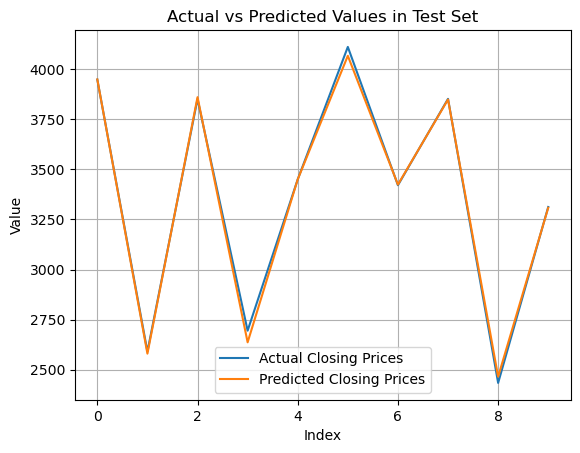

In [34]:
# Compute the difference between the values in the two lists
difference = [abs(a - b) for a, b in zip(test_input_closing_prices, test_output_closing_prices)]

# Create the plot
plt.plot(test_input_closing_prices, label='Actual Closing Prices')
plt.plot(test_output_closing_prices, label='Predicted Closing Prices')
# plt.plot(difference, label='Difference')

# # Display values on the graph
# for i, val in enumerate(test_input_closing_prices):
#     plt.text(i, val, str(val), ha='center', va='top')

# for i, val in enumerate(test_output_closing_prices):
#     plt.text(i, val, str(val), ha='center', va='bottom')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values in Test Set')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [35]:
# Save the model
model.save('model_directory')



In [36]:
# Load the model
loaded_model = tf.keras.models.load_model('model_directory')

In [37]:
# Get the models predicted price values 
predictions = loaded_model.predict(test_input)
predictions = scaler.inverse_transform(predictions)
predictions

1/1 [==============================] - 1s 691ms/step


array([[4287.764 , 3417.0693, 3038.0889, 3957.9182],
       [3325.9539, 2533.2495, 2294.0085, 2926.8853],
       [4283.594 , 3398.9873, 3015.0444, 3924.2969],
       [3385.399 , 2591.511 , 2345.0447, 3003.4712],
       [3993.529 , 3137.1963, 2793.139 , 3628.519 ],
       [4353.0977, 3482.4158, 3103.2515, 4047.5808],
       [4039.4734, 3168.7363, 2817.8752, 3664.358 ],
       [4183.613 , 3326.2356, 2964.3718, 3860.5293],
       [3168.6606, 2392.4624, 2171.328 , 2762.9001],
       [3843.9883, 3009.551 , 2692.7651, 3490.9456]], dtype=float32)

In [87]:
new_stock_data = yf.download('INFY.NS', start="2010-01-01", end="2023-06-29")

[*********************100%***********************]  1 of 1 completed


In [89]:
new_stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,326.250000,328.750000,324.412506,326.575012,240.314362,4069264
2010-01-05,327.500000,328.837494,325.012512,327.668762,241.119217,6895528
2010-01-06,335.375000,335.375000,321.887512,322.887512,237.600891,6817288
2010-01-07,323.325012,323.325012,314.774994,315.631256,232.261292,10892600
2010-01-08,314.875000,315.412506,307.250000,308.024994,226.664139,12649312
...,...,...,...,...,...,...
2023-06-21,1299.949951,1303.800049,1295.000000,1299.349976,1299.349976,4041529
2023-06-22,1289.400024,1289.400024,1273.500000,1281.550049,1281.550049,6676607
2023-06-23,1276.449951,1279.349976,1263.349976,1265.000000,1265.000000,7239467


In [90]:
new_stock_data = new_stock_data[['Open','High','Low','Close']]

In [91]:
new_stock_data

,Open,High,Low,Close
Date,,,,
2010-01-04,326.250000,328.750000,324.412506,326.575012
2010-01-05,327.500000,328.837494,325.012512,327.668762
2010-01-06,335.375000,335.375000,321.887512,322.887512
2010-01-07,323.325012,323.325012,314.774994,315.631256
2010-01-08,314.875000,315.412506,307.250000,308.024994
...,...,...,...,...
2023-06-21,1299.949951,1303.800049,1295.000000,1299.349976
2023-06-22,1289.400024,1289.400024,1273.500000,1281.550049
2023-06-23,1276.449951,1279.349976,1263.349976,1265.000000


In [92]:
new_stock_data = scaled_data = scaler.fit_transform(new_stock_data)

In [93]:
new_stock_data

array([[0.0337119 , 0.03460259, 0.03995607, 0.03649886],
       [0.03446106, 0.03465456, 0.04031472, 0.03715223],
       [0.03918072, 0.03853808, 0.03844674, 0.03429609],
       ...,
       [0.60318835, 0.59929307, 0.60120894, 0.5970789 ],
       [0.59947258, 0.596115  , 0.60055143, 0.60027477],
       [0.6113092 , 0.60959958, 0.61199841, 0.61401411]])

In [94]:
new_stock_data.shape

(3329, 4)

In [95]:
test_input.shape

(10, 3324, 4)

In [96]:
new_stock_data = np.reshape(new_stock_data, (1, new_stock_data.shape[0], 4))

In [97]:
# Get the models predicted price values 
predictions = loaded_model.predict(new_stock_data)
predictions = scaler.inverse_transform(predictions)
predictions

1/1 [==============================] - 0s 211ms/step


array([[1593.5972, 1280.104 , 1193.7816, 1433.6746]], dtype=float32)